In [2]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from scipy import stats

from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

bh kick speed = 100
3e-7 pbh mass
f = 1e-4
long = 1.0
lat = -1.03
distribution of t_es
cadence =
tobs = 1875

In [3]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [4]:
def roman_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of Roman
    #Need to replace this eventually. Assume perfect efficiency for now
    '''
    return 1.0


In [5]:
survey_param_dict = {
    "mock_roman": {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 1825*24, "cadence": 15/60,  "n_sources": 1e7, "efficiency": roman_efficiency, "A_t": 1.34, "survey_area":0},
}

In [6]:
def scientific_format(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"${} \times 10^{{{}}}$".format(mantissa, int(exponent))

def scientific_format_less(x):
    s = "%.1e" % x
    mantissa, exponent = s.split("e")
    return r"$10^{{{}}}$".format(int(exponent))

In [7]:
s = Survey(**survey_param_dict["mock_roman"])
s

Survey(l=1.0, b=-1.03, source_dist=8.5, obs_time=43800, cadence = 0.25, survey_area=0, n_sources=10000000.0, efficiency=<function roman_efficiency at 0x7fced88888b0>)

Line of Sight

In [8]:
def plot_line_of_sight(s, ax):
    d_arr = np.linspace(1, s.source_dist, num=1000)

    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    rho_dm_mw = [s.mw_model.density_dm(d, l = s.l, b = s.b) for d in d_arr]
    ax.plot(d_arr, rho_ffp_mw, label="MW UBOs")
    ax.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")

    ax.set_xlabel(r"$d$ [kpc]", fontsize=16)
    ax.set_ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
    ax.set_title(r'MW Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)

    ax.legend(fontsize=14)

    ax.set_yscale("log")
    ax.set_xlim(1e0, s.source_dist)
    ax.set_ylim(1e5, 1e10)


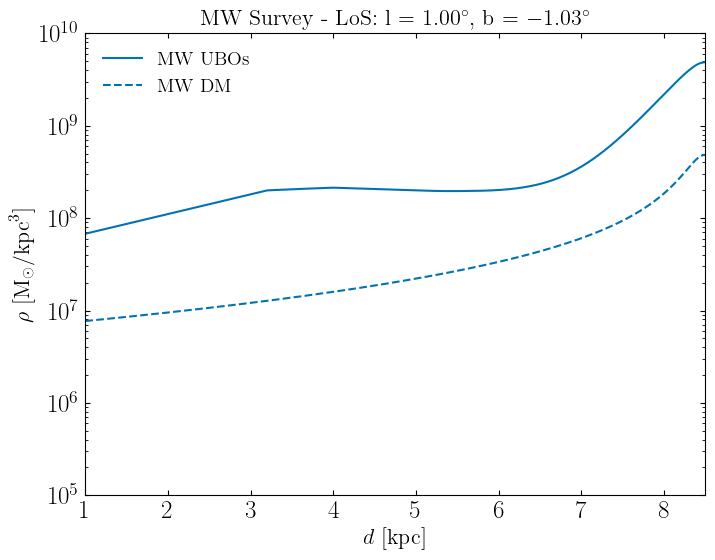

In [9]:
plot_line_of_sight(s, plt.gca())

In [10]:
# Define Time Array
t_es = np.logspace(np.log10(s.cadence)-0.5, np.log10(s.obs_time)+0.5, 60) #hours

In [11]:
#Power law index
p = 1
# m_pbh = 3e-7
m_pbh = 30
# m_pbh = 1e-3
s.add_ffp(p)
s.add_pbh(m_pbh)

### Differential Rates

In [ ]:
pbh_tes_finite = np.array([s.pbh.differential_rate_mw(t, finite=True, v_disp= 280, t_e=True) for t in tqdm(t_es)])

In [13]:
pbh_tes_point = np.array([s.pbh.differential_rate_mw(t, finite=False, v_disp= 400, t_e=True) for t in tqdm(t_es)])


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 60/60 [00:43<00:00,  1.38it/s]


In [13]:
M_norm = 3e-6
Z_fiducial = 10
z_earth =  Z_fiducial/(s.ffp.Z*(M_norm/s.ffp.M_norm)**(-p))

ffp_tes_finite = np.array([s.ffp.differential_rate_mw(t, finite=True, v_disp=None) for t in tqdm(t_es)])
ffp_tes_finite = ffp_tes_finite*z_earth


100%|██████████| 30/30 [02:00<00:00,  4.02s/it]


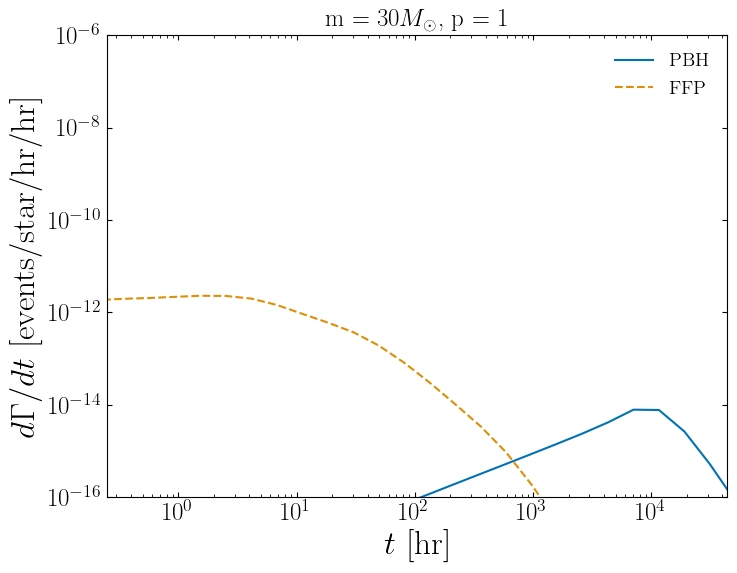

In [14]:
plt.loglog(t_es, pbh_tes_finite, label="PBH", linestyle="-")
plt.loglog(t_es, ffp_tes_finite, label="FFP", linestyle="--")

plt.xlim(s.cadence, s.obs_time)
plt.ylim(1e-16, 1e-6)
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.title("m = {}".format(s.pbh.mass) + r"$M_\odot$, p = {}".format(s.ffp.p))
plt.legend()
plt.show()

In [24]:
def gamma_of_t(dgamma_dt, t):
    t_min = t * 10**(-0.1)
    t_max = t * 10**(0.1)
    diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))
    def diff_rates_interp(t):
        return 10**diff_rates_interp_log(np.log10(t))
    return quad(diff_rates_interp, t_min, t_max)[0]

In [17]:
t_es_limited = np.logspace(np.log10(s.cadence), np.log10(s.obs_time), 60) #hours

In [85]:
gammas_pbh = np.array([gamma_of_t(pbh_tes_finite, t) for t in tqdm(t_es_limited)])
gammas_ffp = np.array([gamma_of_t(ffp_tes_finite, t) for t in tqdm(t_es_limited)])

100%|██████████| 30/30 [00:00<00:00, 2009.22it/s]


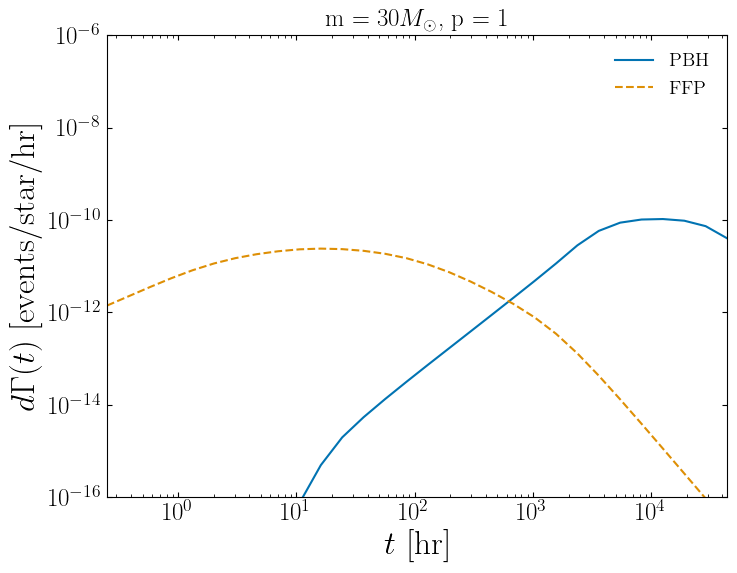

In [18]:
plt.loglog(t_es_limited, gammas_pbh, label="PBH", linestyle="-")
plt.loglog(t_es_limited, gammas_ffp, label="FFP", linestyle="--")

plt.xlim(s.cadence, s.obs_time)
plt.ylim(1e-16, 1e-6)
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma(t)$ [events/star/hr]")
plt.title("m = {}".format(s.pbh.mass) + r"$M_\odot$, p = {}".format(s.ffp.p))
plt.legend()
plt.show()

In [18]:
def my_cdf(sample, x):
        # Counts how many observations are below or equal to x and normalize
        return np.sum(sample <= x) / len(sample)

In [19]:
def sample_crossing_times(t_es, gammas, n_samples):
    norm_gammas = gammas/np.sum(gammas)
    cdf = np.cumsum(norm_gammas)
    
    samples = []
    for _ in range(n_samples):
        r = np.random.rand()
        t_e_sample = np.interp(r, cdf, t_es)
        samples.append(t_e_sample)
    return np.array(samples)

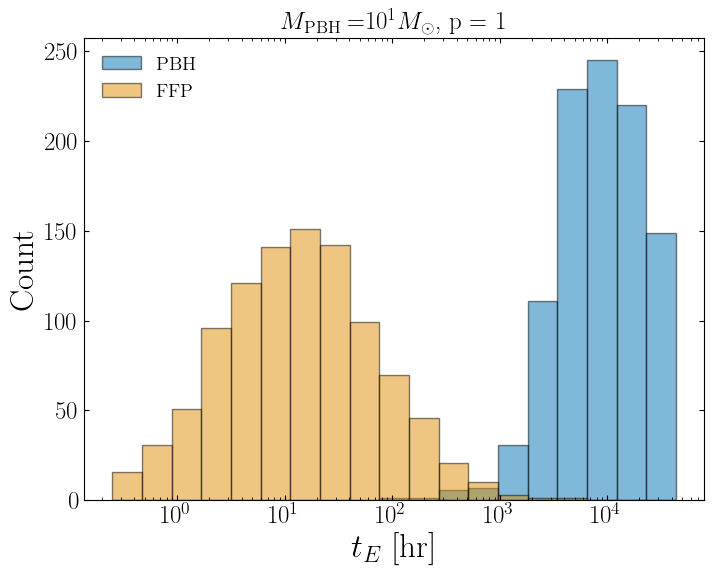

In [21]:
num_samples_pbh = 1000
num_samples_ffp = 1000

samples_pbh = sample_crossing_times(t_es_limited, gammas_pbh, num_samples_pbh)
samples_ffp = sample_crossing_times(t_es_limited, gammas_ffp, num_samples_ffp)

num_bins = 20
bin_counts_pbh, bin_edges_pbh = np.histogram(samples_pbh, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))
bin_counts_ffp, bin_edges_ffp = np.histogram(samples_ffp, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))

# Plotting the histogram
plt.bar(bin_edges_pbh[:-1], bin_counts_pbh, width=np.diff(bin_edges_pbh), align="edge", edgecolor="black", label="PBH", alpha=0.5)
plt.bar(bin_edges_ffp[:-1], bin_counts_ffp, width=np.diff(bin_edges_ffp), align="edge", edgecolor="black", label="FFP", alpha=0.5)
plt.xscale('log')
plt.xlabel("$t_E$ [hr]")
plt.ylabel("Count")
plt.title(r"$M_{\rm{PBH}} = $"  + scientific_format_less(s.pbh.mass) + r"$M_\odot$, p = {}".format(s.ffp.p))
plt.legend()
plt.show()

## Stats

In [20]:
def ks_2samp(sample1, sample2):
     # Gets all unique observations
    observations = np.unique(np.concatenate((sample1, sample2)))
    
    # Computes the CDF for both samples at each observation
    cdf_sample1 = np.array([my_cdf(sample1, x) for x in observations])
    cdf_sample2 = np.array([my_cdf(sample2, x) for x in observations])

    # Computes the KS statistic
    D_ks = np.max(np.abs(cdf_sample1 - cdf_sample2))

    # Calculates the P-Value based on the two-sided test
    m, n = float(len(sample1)), float(len(sample2))
    #Should this just be m or n if they're the same length?
    en = m * n / (m + n)
    p_value = stats.kstwo.sf(D_ks, np.round(en))
#     print(D_ks, np.sqrt((m + n)/(m * n))*1.36)
    # p_value = stats.kstwo.sf(D_ks, np.round(np.sqrt(en)))

    return {"ks_stat": D_ks, "p_value" : p_value}

In [21]:
num_samples_pbh_temp = 0
while True:
    samples_pbh = sample_crossing_times(t_es_limited, gammas_pbh, num_samples_pbh_temp)
    samples_ffp = sample_crossing_times(t_es_limited, gammas_ffp, num_samples_ffp)
    samples_both = np.concatenate((samples_pbh, samples_ffp))
    ks = ks_2samp(samples_ffp, samples_both)
    if ks["p_value"] < 0.05:
        break
    num_samples_pbh_temp += 5

print("Fraction of pbh samples needed to distinguish: ", num_samples_pbh_temp/num_samples_ffp)

NameError: name 'gammas_pbh' is not defined

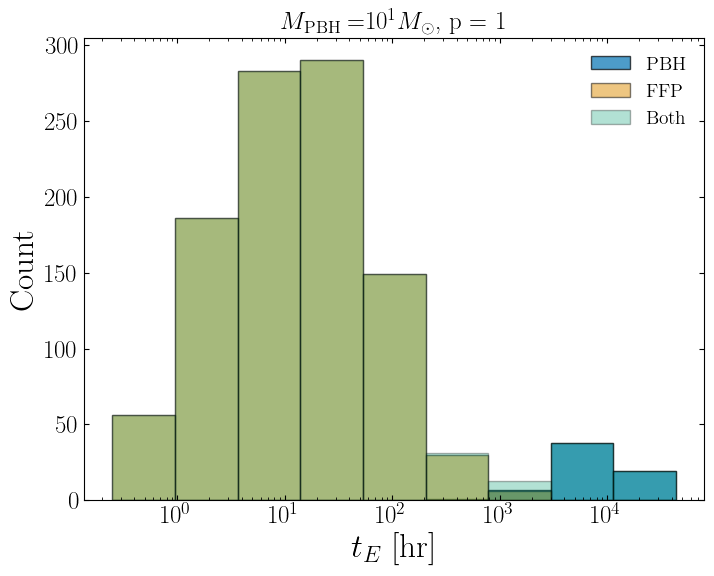

In [37]:
num_bins = 10
bin_counts_pbh, bin_edges_pbh = np.histogram(samples_pbh, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))
bin_counts_ffp, bin_edges_ffp = np.histogram(samples_ffp, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))
bin_counts_both, bin_edges_both = np.histogram(samples_both, bins=np.logspace(np.log10(s.cadence), np.log10(s.obs_time), num_bins))

# Plotting the histogram
plt.bar(bin_edges_pbh[:-1], bin_counts_pbh, width=np.diff(bin_edges_pbh), align="edge", edgecolor="black", label="PBH", alpha=0.7)
plt.bar(bin_edges_ffp[:-1], bin_counts_ffp, width=np.diff(bin_edges_ffp), align="edge", edgecolor="black", label="FFP", alpha=0.5)
plt.bar(bin_edges_both[:-1], bin_counts_both, width=np.diff(bin_edges_both), align="edge", edgecolor="black", label="Both", alpha=0.3)

plt.xscale('log')
plt.xlabel("$t_E$ [hr]")
plt.ylabel("Count")
plt.title(r"$M_{\rm{PBH}} = $"  + scientific_format_less(s.pbh.mass) + r"$M_\odot$, p = {}".format(s.ffp.p))
plt.legend()
plt.show()

### Comparison with popsycle Evan

In [25]:
pbh_tes_finite_30 = np.array([s.pbh.differential_rate_mw(t, finite=True, v_disp= 30) for t in tqdm(t_es)])

100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


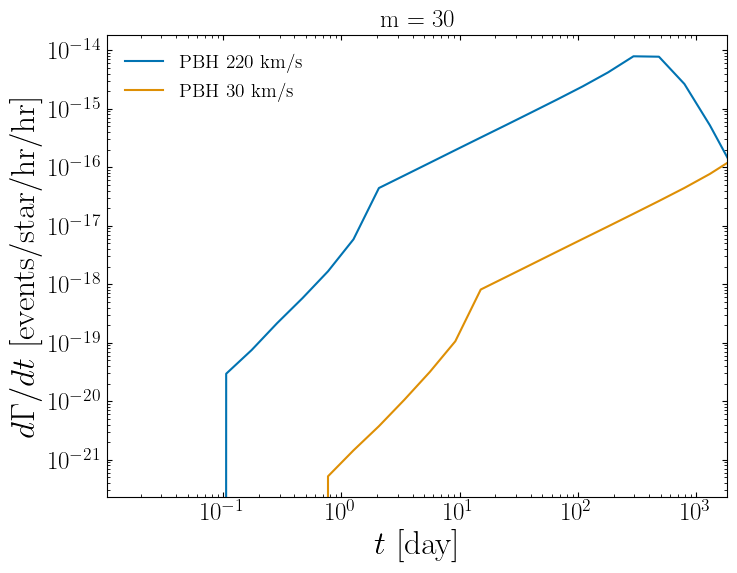

In [26]:
#try bumping up the velcity dispersion of the PBH to 220 km/s

plt.loglog(t_es/24, pbh_tes_finite, label="PBH 220 km/s", linestyle="-")
plt.loglog(t_es/24, pbh_tes_finite_30, label="PBH 30 km/s", linestyle="-")


plt.xlim(s.cadence/24, s.obs_time/24)
# plt.ylim(1e-16, 1e-6)
plt.xlabel(r"$t$ [day]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.title("m = {}".format(s.pbh.mass))
plt.legend()
plt.show()

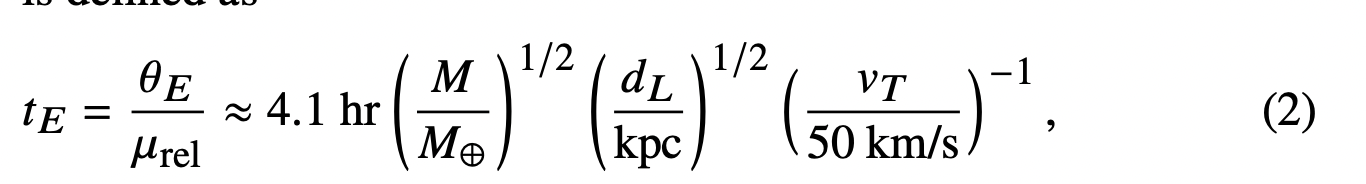

In [22]:
t_e_typical = 4.1 * (1e7)**(1/2) * (4)**(1/2) * (280/50)**(-1) / 24
print(t_e_typical)

192.9365834328922


In [25]:
# gammas_pbh = np.array([gamma_of_t(pbh_tes_finite, t) for t in tqdm(t_es_limited)])
gammas_pbh_point = np.array([gamma_of_t(pbh_tes_point, t) for t in tqdm(t_es_limited)])

# gammas_pbh_30 = np.array([gamma_of_t(pbh_tes_finite_30, t) for t in tqdm(t_es_limited)])


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_42445/1789794238.py:4: RuntimeWarning: divide by zero encountered in log10
  diff_rates_interp_log = interp1d(np.log10(t_es), np.log10(dgamma_dt))
100%|██████████| 60/60 [00:00<00:00, 2215.50it/s]


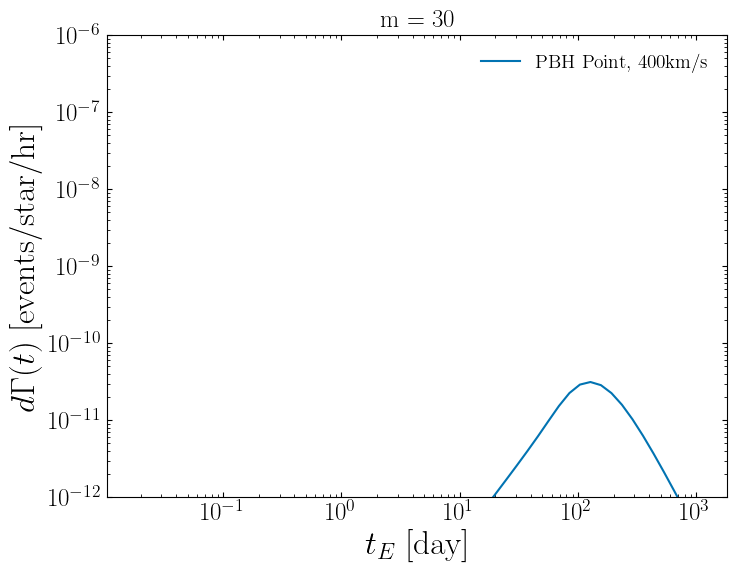

In [26]:
# plt.loglog(t_es_limited/24, gammas_pbh, label="PBH, 280km/s", linestyle="-")
plt.loglog(t_es_limited/24, gammas_pbh_point, label="PBH Point, 400km/s", linestyle="-")

# plt.loglog(t_es_limited/24, gammas_pbh_30, label="PBH, 30km/s", linestyle="-")

plt.xlim(s.cadence/24, s.obs_time/24)
plt.ylim(1e-12, 1e-6)
plt.xlabel(r"$t_E$ [day]")
plt.ylabel(r"$d\Gamma(t)$ [events/star/hr]")
plt.title("m = {}".format(s.pbh.mass))
plt.legend()
plt.show()

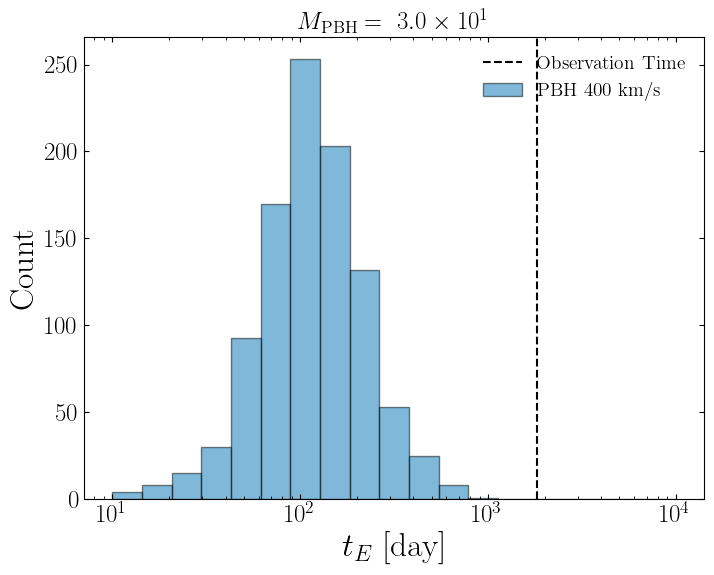

In [27]:
num_samples_pbh = 1000

# samples_pbh = sample_crossing_times(t_es_limited, gammas_pbh, num_samples_pbh)
samples_pbh = sample_crossing_times(t_es_limited, gammas_pbh_point, num_samples_pbh)

# samples_pbh_30 = sample_crossing_times(t_es_limited, gammas_pbh_30, num_samples_pbh)

num_bins = 20
bin_counts_pbh, bin_edges_pbh = np.histogram(samples_pbh/24, bins=np.logspace(1, 4, num_bins))
# bin_counts_pbh_30, bin_edges_pbh_30 = np.histogram(samples_pbh_30/24, bins=np.logspace(1, 4, num_bins))

# Plotting the histogram
plt.bar(bin_edges_pbh[:-1], bin_counts_pbh, width=np.diff(bin_edges_pbh), align="edge", edgecolor="black", label="PBH 400 km/s", alpha=0.5)
# plt.bar(bin_edges_pbh_30[:-1], bin_counts_pbh_30, width=np.diff(bin_edges_pbh_30), align="edge", edgecolor="black", label="PBH 30 km/s", alpha=0.5)

plt.axvline(s.obs_time/24, color="black", linestyle="--", label="Observation Time")
# plt.axvline(t_e_typical, color="red", linestyle="--", label=r"Typical $t_E$")

plt.xscale('log')
# plt.yscale('log')
plt.xlabel("$t_E$ [day]")
plt.ylabel("Count")
plt.title(r"$M_{\rm{PBH}} = ~$"  + scientific_format(s.pbh.mass))
plt.legend()
plt.show()

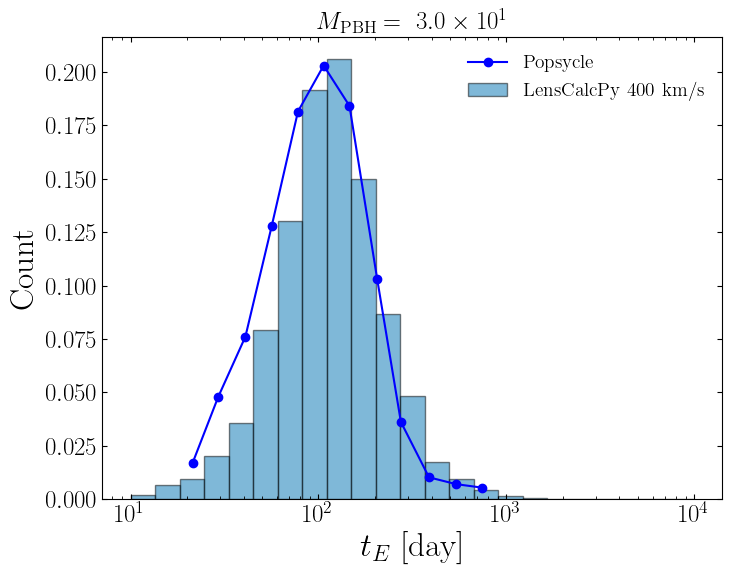

In [49]:
num_samples_pbh = 10000
samples_pbh = sample_crossing_times(t_es_limited, gammas_pbh_point, num_samples_pbh)
num_bins = 24
bin_counts_pbh, bin_edges_pbh = np.histogram(samples_pbh/24, bins=np.logspace(1, 4, num_bins))

plt.bar(bin_edges_pbh[:-1], bin_counts_pbh/np.sum(bin_counts_pbh), width=np.diff(bin_edges_pbh), align="edge", edgecolor="black", label="LensCalcPy 400 km/s", alpha=0.5)

# plt.axvline(s.obs_time/24, color="black", linestyle="--", label="Observation Time")


x = [21.39154789826256, 29.2832673143766, 40.84372112156074, 56.37043772527345, 77.79145561997345, 
     106.54379618701142, 146.23929608585925, 205.16629102338942, 274.578895175973, 387.67176368534706, 
     541.6263286087639, 742.7356736774384]
y = np.array([14.747753500889473, 41.51142635588192, 65.89677507640377, 110.64566893217169, 157.09141084705556, 
     175.71021301829126, 159.37394517173743, 89.41454180540983, 31.33991698216485, 8.890890845231013, 
     6.126670619896885, 4.72266569356384])

plt.plot(x, y/np.sum(y), '-o', color='blue', label="Popsycle")
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("$t_E$ [day]")
plt.ylabel("Count")
plt.title(r"$M_{\rm{PBH}} = ~$"  + scientific_format(s.pbh.mass))
plt.legend()
plt.show()